In [94]:
import spacy
import json
import os
import codecs
import numpy as np
import networkx as nx
import pandas as pd
from pprint import pprint
from spacy import displacy
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def load_json_files(path_to_json):
    ####################
    #print(path_to_json)
    ####################
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    #######################
    #print(json_files[3:4])
    #######################
    json_objects = list()
    for index, js in enumerate(json_files):
        #######################
        #print(index, ": ", js)
        #######################
        with open(os.path.join(path_to_json, js)) as json_file:
            json_objects.append(json.load(json_file))
    #####################
    #pprint(json_objects)
    #####################
    
    del json_objects[3]
    del json_objects[28-1]
    del json_objects[75-2]
    del json_objects[114-3]
    del json_objects[175-4]
    del json_objects[238-5]
    del json_objects[261-6]
    del json_objects[279-7]
    del json_objects[327-8]
    del json_objects[364-9]
    del json_objects[374-10]
    del json_objects[402-11]
    del json_objects[406-12]
    
    return json_objects#[:1]
##### index number 3, 28, 75, 114, 175, 238, 261, 279, 327, 364, 374, 402, 406 has denotation_span = None

In [29]:
stopwords_en = None
with open("stopwords-en.txt", "rt", encoding="utf-8-sig") as infile:
    stopwords_en = json.load(infile)["en"]
#print(stopwords_en)

In [30]:
nlp = spacy.load("en")

In [31]:
#denotations vs global id dictionary
span_g_id = dict()
#get set of class from relation pred
class_set = set()

In [32]:
def generate_token_denotation(denotation, denotation_span):
    
    token_denotation_info = dict()

    token_denotation_info = {"span" : denotation_span, "obj" : denotation["obj"],"tag" : dict()}#, "relation" : json_object_relations}
    
    #getting tag of tokens in denotation_span(disease or gene or expression)
    for token in denotation_span:
        if str(token) in token_denotation_info["tag"]:
            if str(token.tag_) in token_denotation_info["tag"][str(token)]:
                token_denotation_info["tag"][str(token)][str(token.tag_)] += 1
                ##
#                print(token_denotation_info[span_g_id[denotation_span_str]]["tag"][token])
            else:
                token_denotation_info["tag"].update({str(token) : {str(token.tag_) : 1}})
        else:
            token_denotation_info["tag"].update({str(token) : {str(token.tag_) : 1}})

    return token_denotation_info;

In [33]:
def update_token_denotation_infos(token_denotation_infos, denotation_span):
    denotation_span_str = str(denotation_span)
    for token in denotation_span:                
        if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
            if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                ##
#               print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
            else:
                token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
        else:
            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
    return token_denotation_infos

In [34]:
def get_sentences_containing_denotations(sentence_with_denotation, text, denotation, no_pre_post):
    words = list()
    sentence_index = 0
    for idx, sent in enumerate(text.sents):
        if(denotation.start >= sent.start and denotation.end < sent.end):
            #print(sent)
            tmp_words = list()
            if(denotation.start != sent.start):
                pr_w = text[denotation.start-1]
                for i in range(0,no_pre_post):
                    if(pr_w.i-1 >= sent.start):
                        while(pr_w.string.strip() in stopwords_en):
                            pr_w = text[pr_w.i-1]
                        tmp_words.append(pr_w.string.strip())
                        pr_w = text[pr_w.i-1]
            
            words = [x for x in reversed(tmp_words)]
            words.append(denotation.string.strip())
            
            if(denotation.end != sent.end):
                ps_w = text[denotation.end]
                for i in range(0,no_pre_post):
                    if(ps_w.i+1 < sent.end):
                        while(ps_w.string.strip() in stopwords_en):
                            ps_w = text[ps_w.i+1]
                        words.append(ps_w.string.strip())
                        ps_w = text[ps_w.i+1]
            
            sentence_index = idx
            
            if(sent.string.strip() in sentence_with_denotation):
                sentence_with_denotation[sent.string.strip()].append(denotation.string.strip())
            else:
                sentence_with_denotation[sent.string.strip()] =[denotation.string.strip()]
    return sentence_with_denotation, words, sentence_index

In [35]:
def get_class_list(pred):
    class_list = set()
    class_list.add(pred)
    return class_list

In [36]:
def generate_token_info(json_objects, no_pre_post):
    
    token_denotation_infos = dict()
    token_relation_infos = dict()
    sentences_by_article = dict()
    words_by_article = dict()
    
    #count for gene disease and expression
    gene_count = 1
    disease_count = 1
    #regulation_count = 1
    
    #iterate through the json objects
    for jindex,json_object in enumerate(json_objects): 
        json_object_text = json_object["text"]
        json_object_denotations = json_object["denotations"]
        json_object_relations = json_object["relations"]
        json_object_pubmed_id = json_object["sourceid"]
        
        expression_count = 1
        
        ##
        #pprint(json_object_relations)
        #print()
        
        #parsing text using spacy
        parsed_text = nlp(json_object_text)
        
        #local and global id dictionary for each json object
        lg_id = dict()
        sentence_with_denotation = dict()
        words_by_article[json_object_pubmed_id] = dict()
        
        #iterate through denotation within json object
        for index,denotation in enumerate(json_object_denotations):
            denotation_start = denotation["span"]["begin"]
            denotation_end = denotation["span"]["end"]
            denotation_span = parsed_text.char_span(denotation_start, denotation_end)
            denotation_span_str = str(denotation_span)
            
            #print(str(denotation_span.rights))
            
            sentence_with_denotation, words_by_article[json_object_pubmed_id][denotation_span_str], sent_idx = get_sentences_containing_denotations(sentence_with_denotation, parsed_text, denotation_span, no_pre_post)
            #return
            ##
#             print("[", jindex, "]", denotation, "-> ", denotation_span, " : ", denotation_span_str)
            
            if denotation_span_str in span_g_id:
                token_denotation_infos = update_token_denotation_infos(token_denotation_infos, denotation_span)
                lg_id[denotation["id"]] = span_g_id[denotation_span_str]
            else:
                if ("expression" in denotation["obj"].lower() or "regulation" in denotation["obj"].lower()):
                    key = "e_" + json_object_pubmed_id + "_" + str(sent_idx) + "_" + str(expression_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    expression_count += 1

                elif ("cancer" in denotation["obj"].lower()):
                    key = "d_" + str(disease_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    disease_count += 1

                elif ("gene" in denotation["obj"].lower()):
                    key = "g_" + str(gene_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    gene_count += 1
                    
                else:
                    print("EXCEPTION: ", denotation, "-> ", denotation_span)
                    span_g_id[denotation_span_str] = "EXCEPTION"
                    lg_id[denotation["id"]] = "EXCEPTION"
        #return
        sentences_by_article[json_object_pubmed_id] = sentence_with_denotation
        ##
        #print(lg_id)
        #print()

        relations = list()
        for index,relation in enumerate(json_object_relations):
            relations.append({"subj" : lg_id[relation["subj"]], "obj" : lg_id[relation["obj"]], "pred" : relation["pred"]})
            class_set.add(relation["pred"])
        token_relation_infos[json_object_pubmed_id] = relations
##
#     print(span_g_id)
    #pprint(token_denotation_infos)
    #print()
    #pprint(token_relation_infos)
    
    return token_denotation_infos, token_relation_infos, sentences_by_article, words_by_article

In [37]:
path_to_json = "F:/UB/2nd Sem/Basic Projects/Graph Data mining for Gene Cancer relation/CoMAGC-annotations/CoMAGC/"
json_objects = load_json_files(path_to_json)
nodes_info, edges_info, sentences, bag_of_words = generate_token_info(json_objects,3)
id_g_span = {y:x for x,y in span_g_id.items()}
print(sentences)
print("-----------------------------------------------------------------------------------------------------")
print(bag_of_words)
print("-----------------------------------------------------------------------------------------------------")
print(span_g_id)
print("-----------------------------------------------------------------------------------------------------")
print(id_g_span)
print("-----------------------------------------------------------------------------------------------------")
print(edges_info)
print("-----------------------------------------------------------------------------------------------------")
print(class_set)

{'10067845': {'In conclusion, our results demonstrate that growth inhibition of LNCaP cells by 1,25-(OH)2D3 and 9-cis RA is mediated by an AR-dependent mechanism and preceded by the induction of AR gene expression.': ['LNCaP', 'induction', 'AR gene', 'expression']}, '10216950': {'A broad spectrum of tumor derived cell lines, from varied tissue sources and blood samples from patients having confirmed prostate carcinoma, all scored positive for expression of PTI-1, while corresponding normal tissues or blood samples were negative.': ['prostate carcinoma', 'positive', 'expression', 'PTI-1']}, '10323669': {'It has been shown recently that 17beta-estradiol (E2) can stimulate the Src/p21ras/mitogen-activated protein kinase pathway in breast cancer cells, and this effect is supposed to mediate the E2-induced stimulation of breast cancer cell proliferation, possibly via activation of the c-fos and c-jun early genes or of genes involved in cell cycle control.': ['stimulate', 'Src/p21ras/mitogen


-----------------------------------------------------------------------------------------------------


{'10067845': {'LNCaP': ['demonstrate', 'growth', 'inhibition', 'LNCaP', 'cells', '1,25-(OH)2D3', '9-cis'], 'induction': ['dependent', 'mechanism', 'preceded', 'induction', 'AR', 'gene', 'expression'], 'AR gene': ['mechanism', 'preceded', 'induction', 'AR gene', 'expression'], 'expression': ['induction', 'AR', 'gene', 'expression']}, '10216950': {'prostate carcinoma': ['samples', 'patients', 'confirmed', 'prostate carcinoma', 'scored', 'positive', 'expression'], 'positive': ['prostate', 'carcinoma', 'scored', 'positive', 'expression', 'PTI-1', 'normal'], 'expression': ['carcinoma', 'scored', 'positive', 'expression', 'PTI-1', 'normal', 'tissues'], 'PTI-1': ['scored', 'positive', 'expression', 'PTI-1', 'normal', 'tissues', 'blood']}, '10323669': {'stimulate': ['(', 'E2', ')', 'stimulate', 'Src', '/', 'p21ras'], 'Src/p21ras/mitogen-activated protein kinase': ['E2', ')', 'stimulate', 'Src/p21ras/mitogen-activated protein kinase', 'pathway', 'breast', 'cancer'], 'breast cancer': ['mediate',

-----------------------------------------------------------------------------------------------------


{'LNCaP': 'd_1', 'induction': 'e_10067845_15_1', 'AR gene': 'g_1', 'expression': 'e_10067845_15_2', 'prostate carcinoma': 'd_2', 'positive': 'e_10216950_8_1', 'PTI-1': 'g_2', 'stimulate': 'e_10323669_2_1', 'Src/p21ras/mitogen-activated protein kinase': 'g_3', 'breast cancer': 'd_3', 'PA1': 'd_4', 'activin': 'g_4', 'overexpression': 'e_10342830_20_1', 'Overexpression': 'e_10397458_5_1', 'c-erbB-2 oncoprotein': 'g_5', 'epithelial ovarian cancers': 'd_5', 'ovarian cancers': 'd_6', 'ovarian tumours': 'd_7', 'activate': 'e_10408832_8_1', 'proMMP-2': 'g_6', 'FRalpha': 'g_7', 'overexpressed': 'e_10419053_1_1', 'ovarian carcinoma': 'd_8', 'Drg1': 'g_8', 'upregulated': 'e_10428464_0_1', 'prostatic adenocarcinoma': 'd_9', 'up-regulation': 'e_10449619_6_1', 'PyNPase': 'g_9', 'mammary adenocarcinoma': 'd_10', 'repression': 'e_10498868_7_1', 'ING1': 'g_10', 'Elevated': 'e_10590366_2_1', 'Met': 'g_11', 'carcinoma of the prostate': 'd_11', 'loss': 'e_10602481_7_1', 'E-cadherin': 'g_12', 'breast cance

-----------------------------------------------------------------------------------------------------


{'d_1': 'LNCaP', 'e_10067845_15_1': 'induction', 'g_1': 'AR gene', 'e_10067845_15_2': 'expression', 'd_2': 'prostate carcinoma', 'e_10216950_8_1': 'positive', 'g_2': 'PTI-1', 'e_10323669_2_1': 'stimulate', 'g_3': 'Src/p21ras/mitogen-activated protein kinase', 'd_3': 'breast cancer', 'd_4': 'PA1', 'g_4': 'activin', 'e_10342830_20_1': 'overexpression', 'e_10397458_5_1': 'Overexpression', 'g_5': 'c-erbB-2 oncoprotein', 'd_5': 'epithelial ovarian cancers', 'd_6': 'ovarian cancers', 'd_7': 'ovarian tumours', 'e_10408832_8_1': 'activate', 'g_6': 'proMMP-2', 'g_7': 'FRalpha', 'e_10419053_1_1': 'overexpressed', 'd_8': 'ovarian carcinoma', 'g_8': 'Drg1', 'e_10428464_0_1': 'upregulated', 'd_9': 'prostatic adenocarcinoma', 'e_10449619_6_1': 'up-regulation', 'g_9': 'PyNPase', 'd_10': 'mammary adenocarcinoma', 'e_10498868_7_1': 'repression', 'g_10': 'ING1', 'e_10590366_2_1': 'Elevated', 'g_11': 'Met', 'd_11': 'carcinoma of the prostate', 'e_10602481_7_1': 'loss', 'g_12': 'E-cadherin', 'd_12': 'brea

-----------------------------------------------------------------------------------------------------


{'10067845': [{'subj': 'g_1', 'obj': 'e_10067845_15_2', 'pred': 'themeOf'}, {'subj': 'e_10067845_15_2', 'obj': 'e_10067845_15_1', 'pred': 'themeOf'}, {'subj': 'g_1', 'obj': 'd_1', 'pred': 'CGE-increased'}, {'subj': 'g_1', 'obj': 'd_1', 'pred': 'IGE-unidentifiable'}, {'subj': 'g_1', 'obj': 'd_1', 'pred': 'CCS-cancerTOnormal'}, {'subj': 'g_1', 'obj': 'd_1', 'pred': 'PT-observation'}], '10216950': [{'subj': 'g_2', 'obj': 'e_10067845_15_2', 'pred': 'themeOf'}, {'subj': 'e_10067845_15_2', 'obj': 'e_10216950_8_1', 'pred': 'themeOf'}, {'subj': 'g_2', 'obj': 'd_2', 'pred': 'CGE-increased'}, {'subj': 'g_2', 'obj': 'd_2', 'pred': 'IGE-unchanged'}, {'subj': 'g_2', 'obj': 'd_2', 'pred': 'CCS-normalTOcancer'}, {'subj': 'g_2', 'obj': 'd_2', 'pred': 'PT-observation'}], '10323669': [{'subj': 'g_3', 'obj': 'e_10323669_2_1', 'pred': 'themeOf'}, {'subj': 'g_3', 'obj': 'd_3', 'pred': 'CGE-increased'}, {'subj': 'g_3', 'obj': 'd_3', 'pred': 'IGE-unidentifiable'}, {'subj': 'g_3', 'obj': 'd_3', 'pred': 'CCS-n

-----------------------------------------------------------------------------------------------------
{'IGE-unidentifiable', 'PT-causality', 'CCS-unidentifiable', 'CGE-decreased', 'CCS-cancerTOnormal', 'CCS-normalTOcancer', 'themeOf', 'IGE-', 'CGE-increased', 'IGE-up-regulated', 'PT-', 'PT-observation', 'IGE-unchanged'}


In [89]:
def get_data(relations, sents, words, ids):
    base_classes = {"CGE", "CCS", "IGE", "PT"}
    data = dict()
    for pmid,vr in relations.items():
        data[pmid] = dict()
        for r in vr:
            if "-" in r["pred"] and r["pred"].split("-")[0] in base_classes:
                for sent,vs in sents[pmid].items():
                    if(ids[r["subj"]] in vs and ids[r["obj"]] in vs):
                        #print(r["pred"])
                        #data[pmid][sent] = dict()
                        subj_words =["subj_" + x for x in words[pmid][ids[r["subj"]]]]
                        obj_words = ["obj_" + x for x in words[pmid][ids[r["obj"]]]]
                        #merged = subj_words + obj_words
                        if(sent in data[pmid]):
                            data[pmid][sent].update({r["pred"] : subj_words + obj_words})
                        else:
                            data[pmid].update({sent : {r["pred"] : subj_words + obj_words}})
                        #print(data)
                        #data[pmid][sent][r["pred"]] = subj_words + obj_words
    return data
                

In [99]:
def write_file(data):
    file_content = ""
    for pmid, vd in data.items():
        for sent, vs in vd.items():
            for cls, vc in vs.items():
                file_content = file_content + pmid + "\t" + sent + "\t" + cls + "\t" + " ".join(vc) + "\n"
                
    

    #file = codecs.open("lebeled_data.txt", "w", "utf-8")
    #file.write(file_content'\ufeff')
    #file.close()
    
    with codecs.open("lebeled_data.txt", "w", encoding='utf8') as f:
        f.write(file_content)
        f.close()

In [100]:
data_to_write = get_data(edges_info, sentences, bag_of_words, id_g_span)
write_file(data_to_write)
#print(data_to_write)

In [38]:
def get_nodes_labels(node_infos):
    nodes = list()
    n_labels = dict()
    for node,info in node_infos.items():
        nodes.append(node)
        n_labels[node] = str(info["span"])
    return nodes, n_labels

def get_edge_labels(edge_infos):
    e_labels = dict()
    for k,edges in edge_infos.items():
        for edge in edges:
            e_labels[(edge["subj"],edge["obj"])] = e_labels.get((edge["subj"],edge["obj"]), edge["pred"]) + "/" + edge["pred"]
    return e_labels

def get_edges_labels_weights():
    labels = get_edge_labels(edges_info)
    e_labels = dict()
    edges = list()
    for key, value in labels.items():
        v_arr = value.split("/")
        v_dict = dict()
        weight = 0
        l = ""
        for x in v_arr:
            v_dict[x] = v_dict.get(x,0) + 1
        k_list = list(v_dict.keys())
        for k, v in v_dict.items():
            if k == k_list[-1]:
                l += str(k) + "*" + str(v)
            else:
                l += str(k) + "*" + str(v) + ", "
            weight += v
        nkey = key + (weight,)
        e_labels[key] = l
        edges.append(nkey)
#         for et, el in e_labels.items():
#             edges.append(et)
            #e_labels[et] = el
    return edges, e_labels

In [39]:
def compute_node_size(min_degree, max_degree, nds):
    node_sizes = list()
    for nd in nds:
        node_sizes.append(list(nd))
                          
    for index,nd in enumerate(node_sizes):
        if nd[1] == 0:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*0.5
        else:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*nd[1]
                          
    return node_sizes

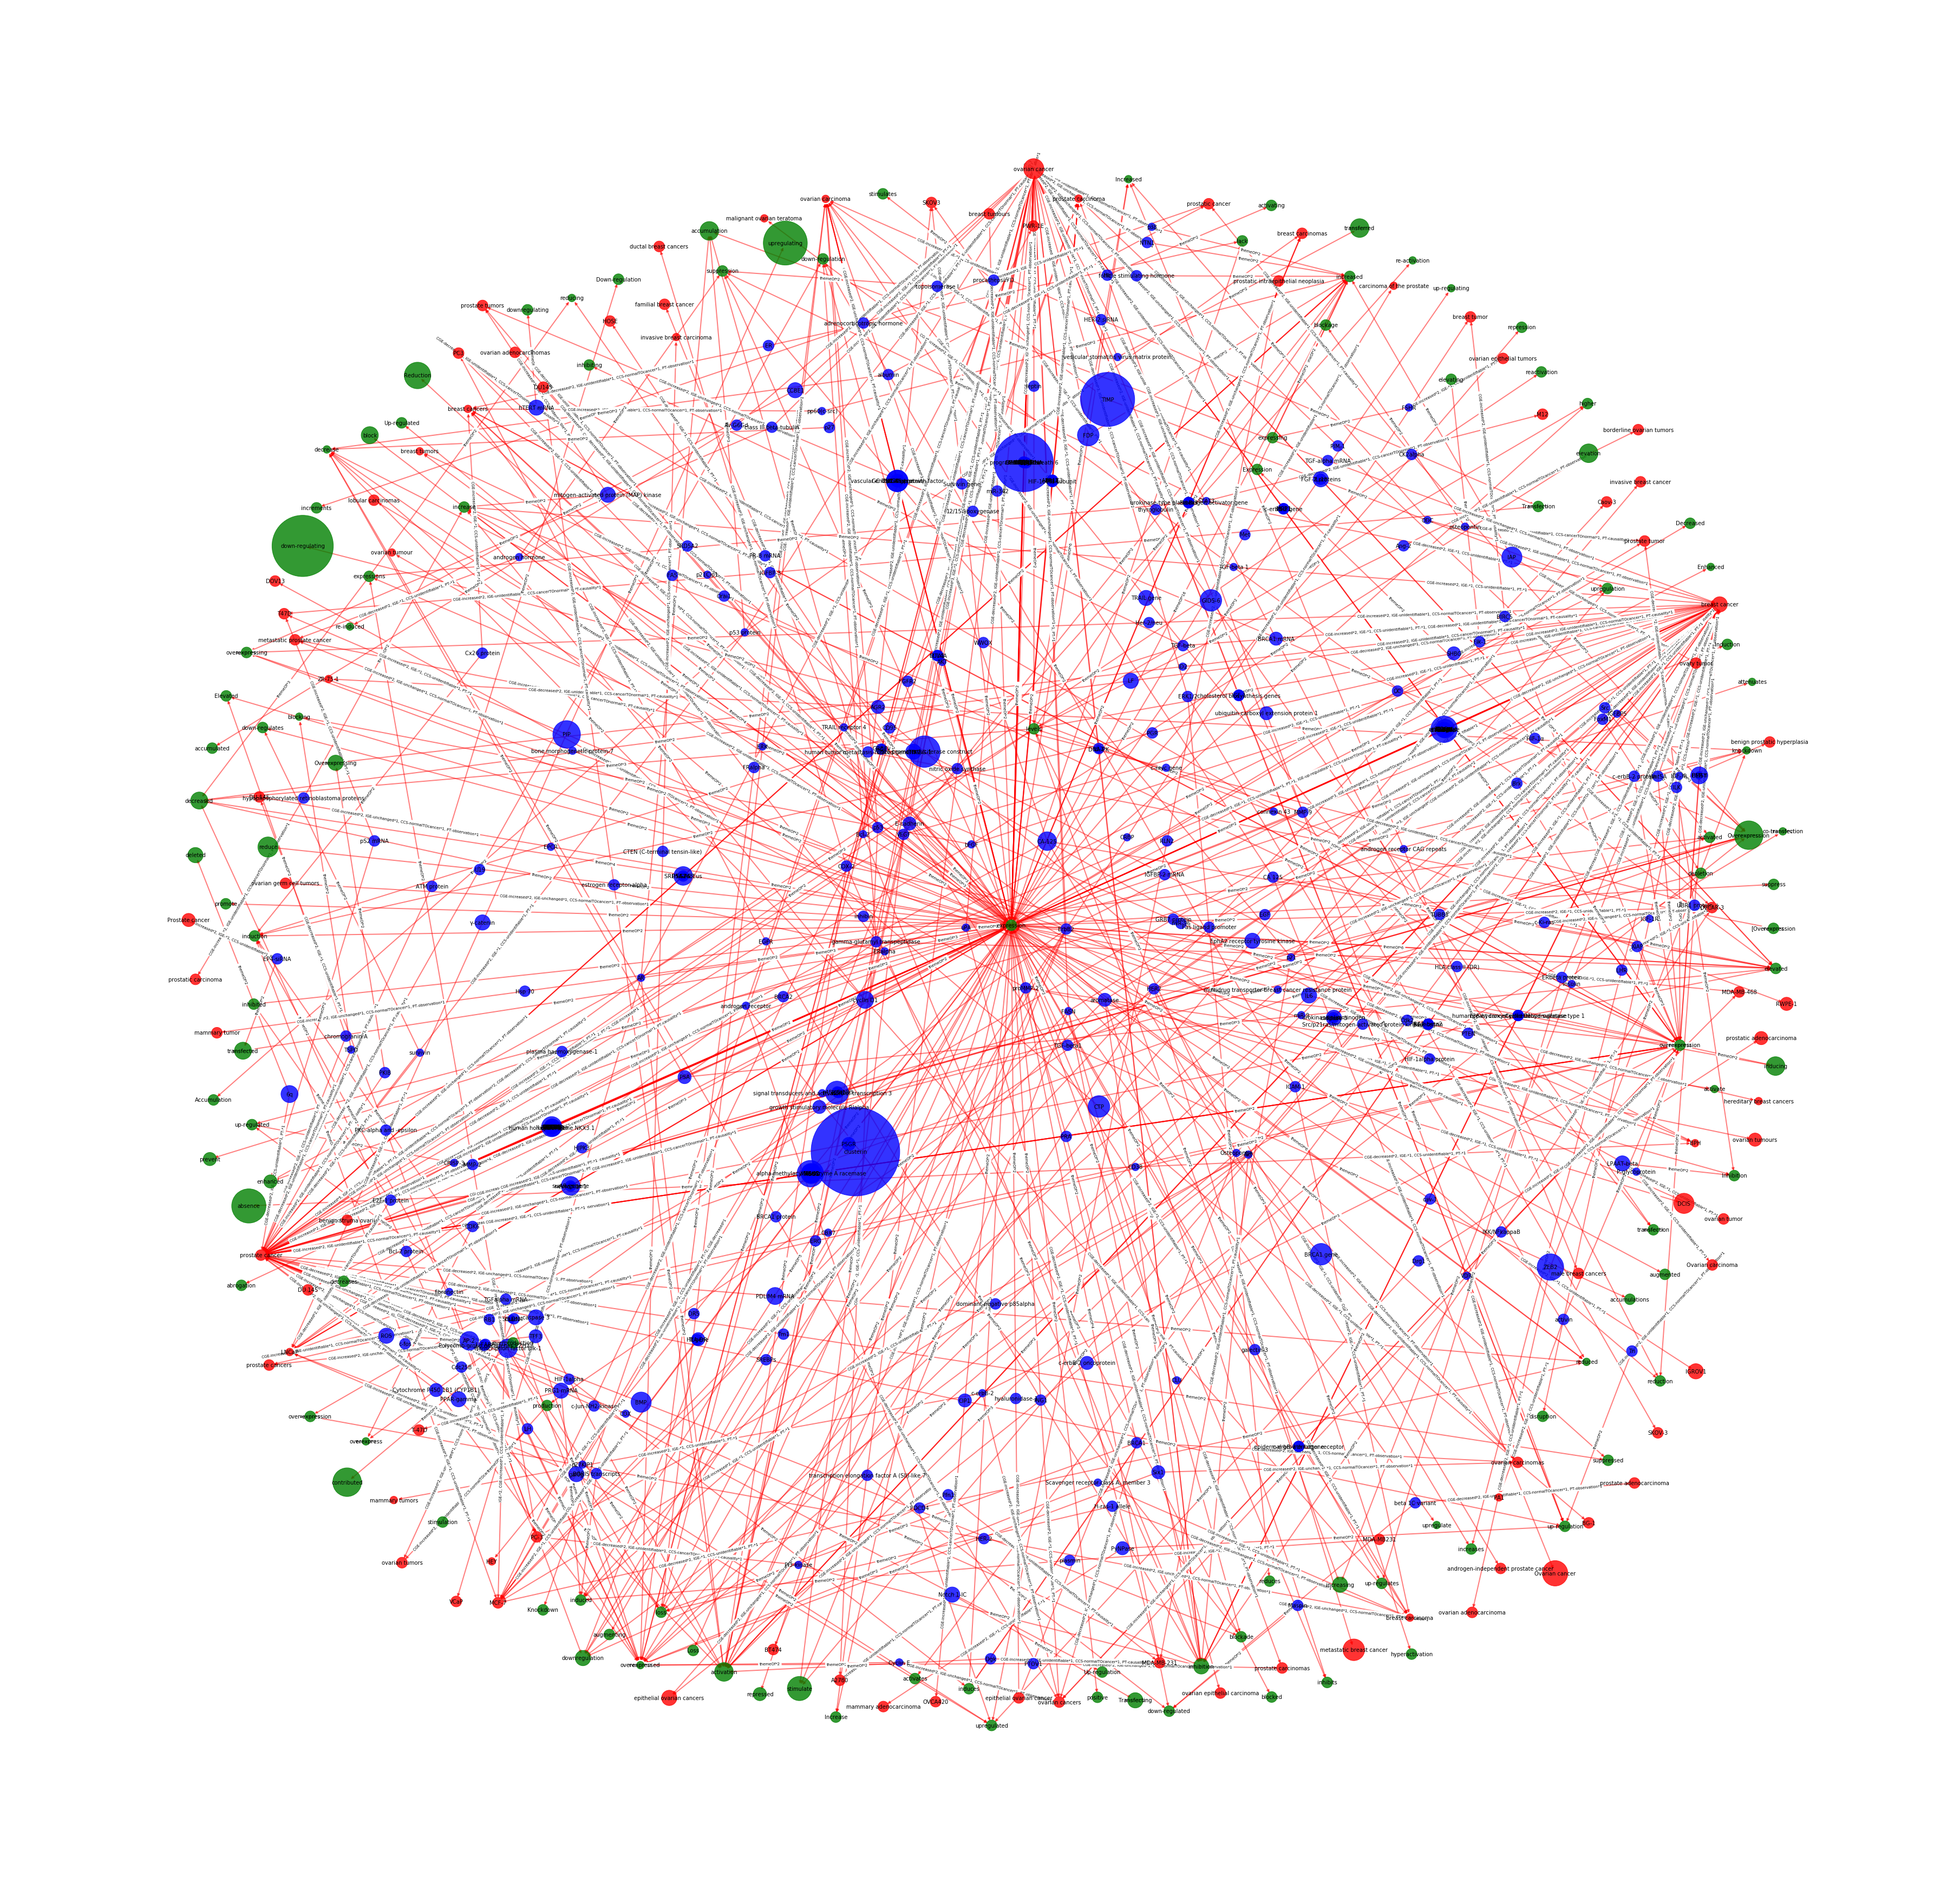

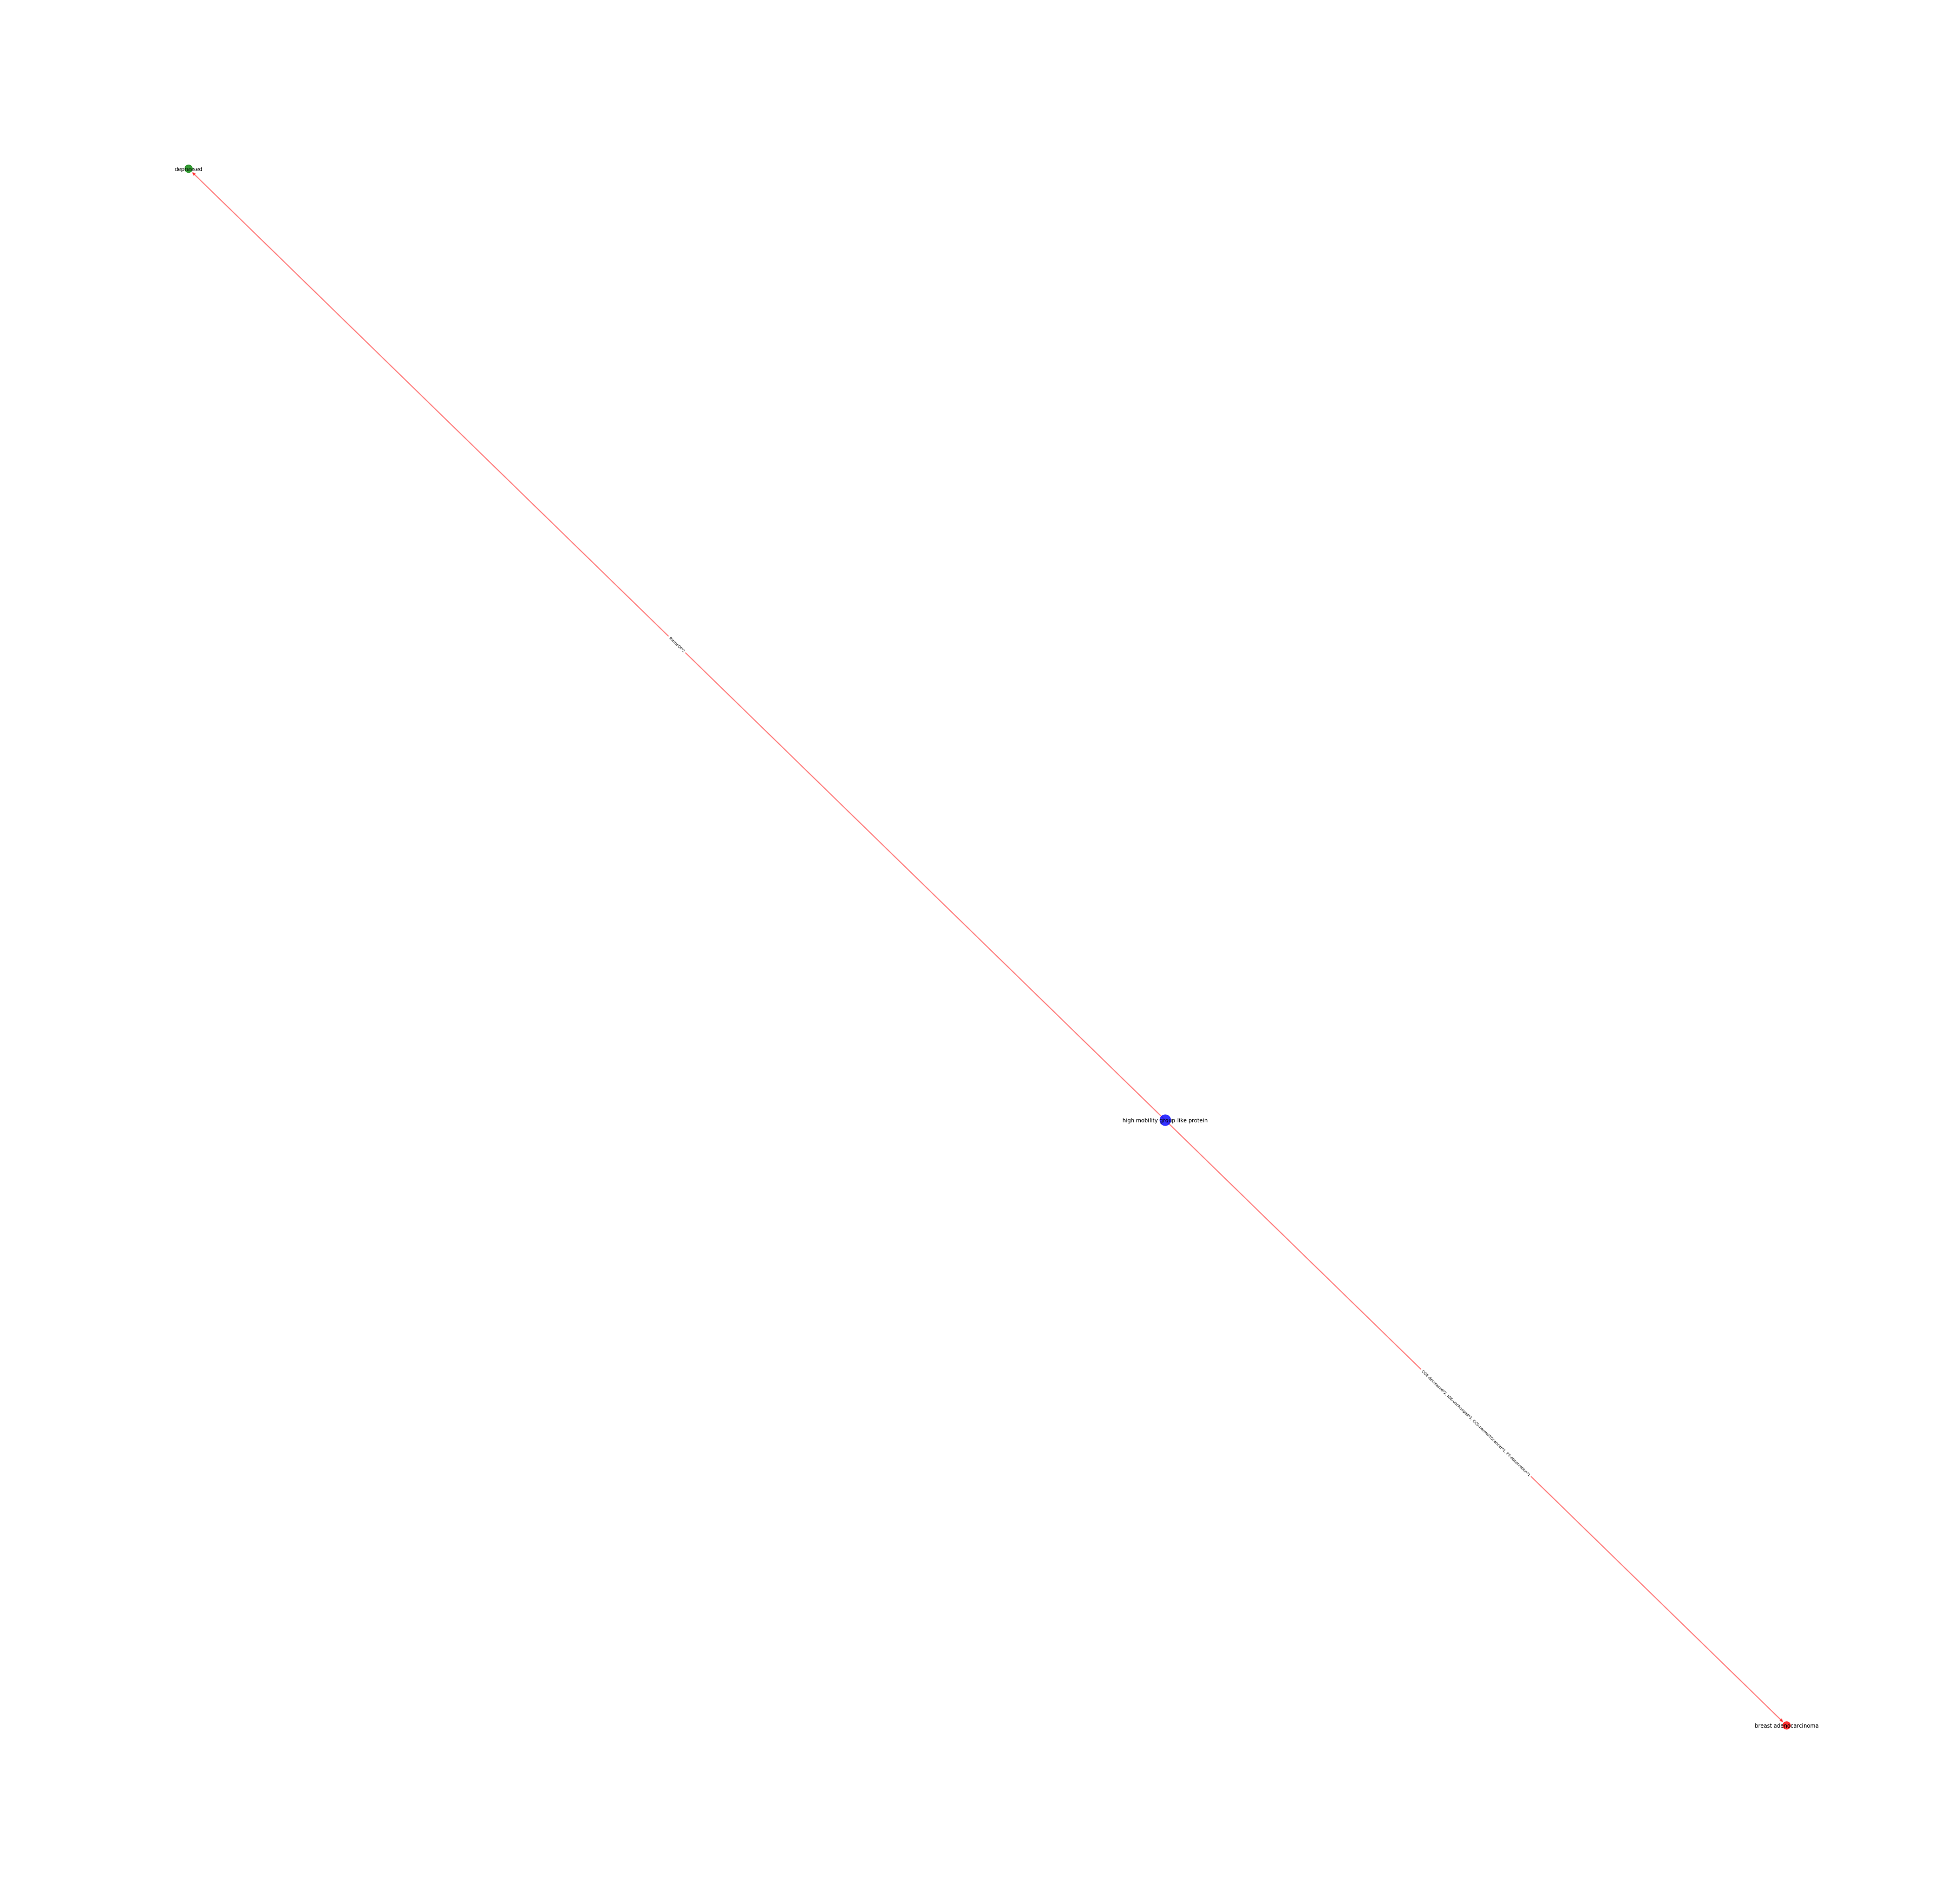

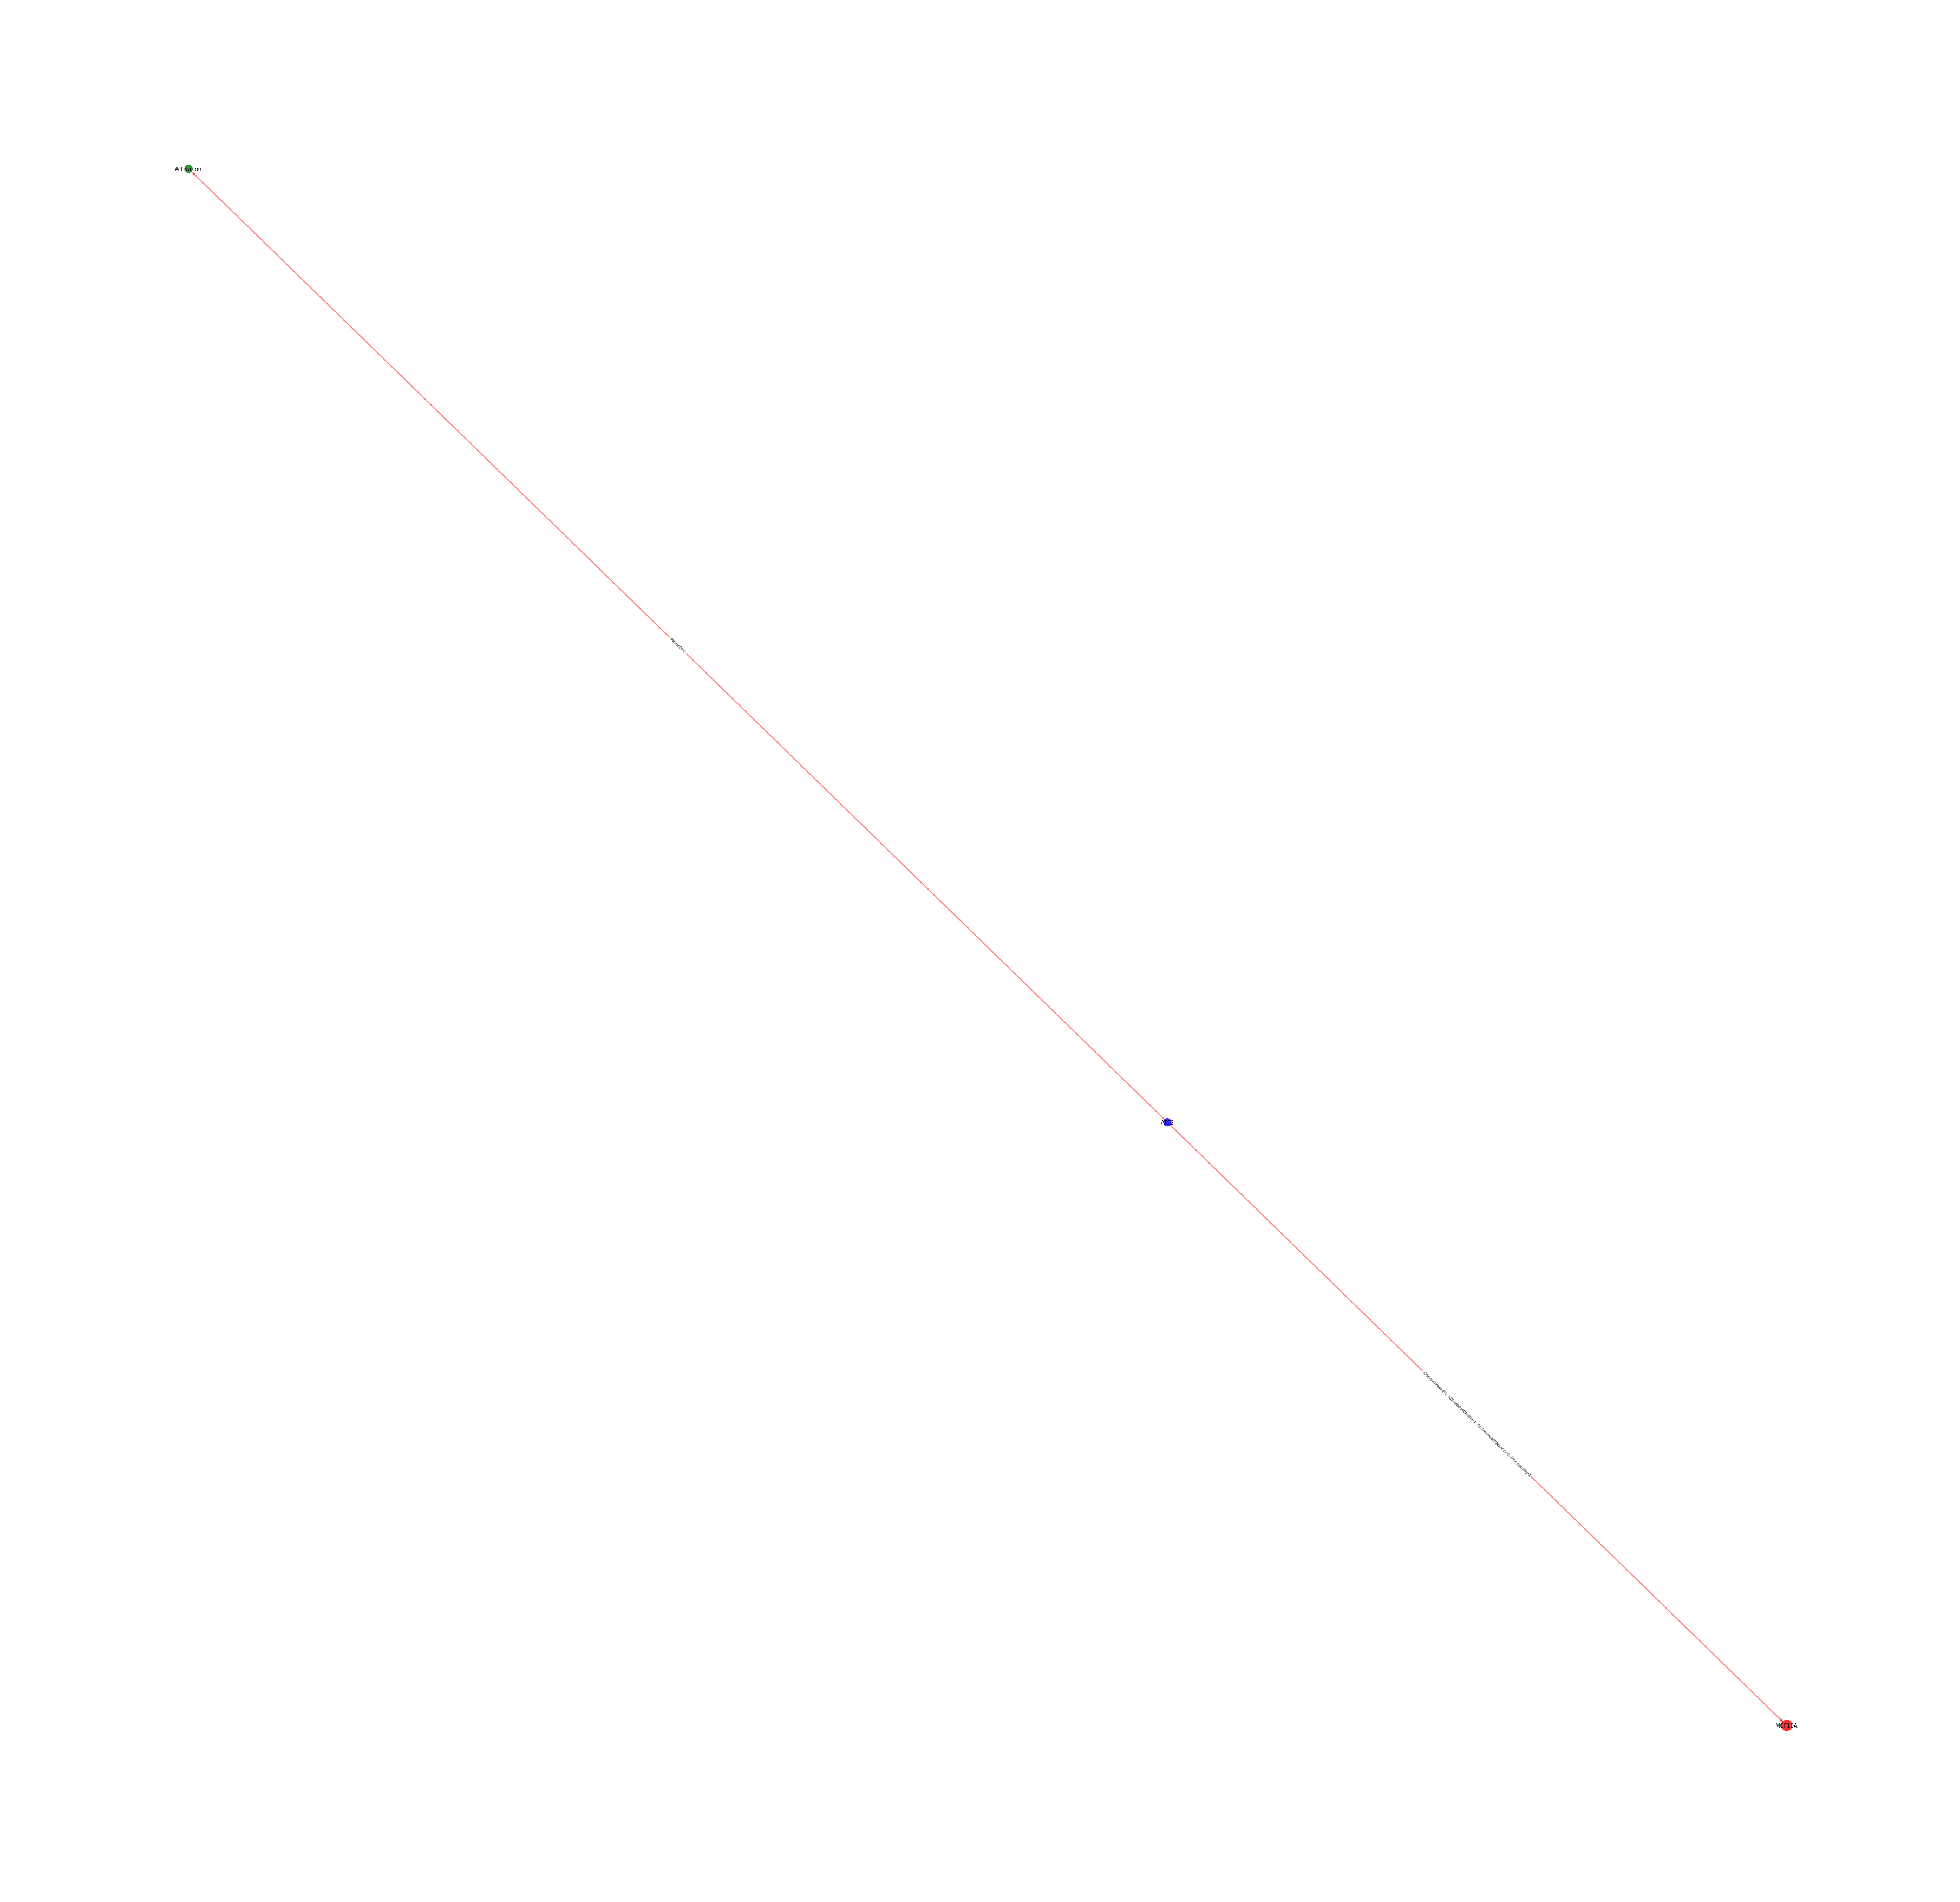

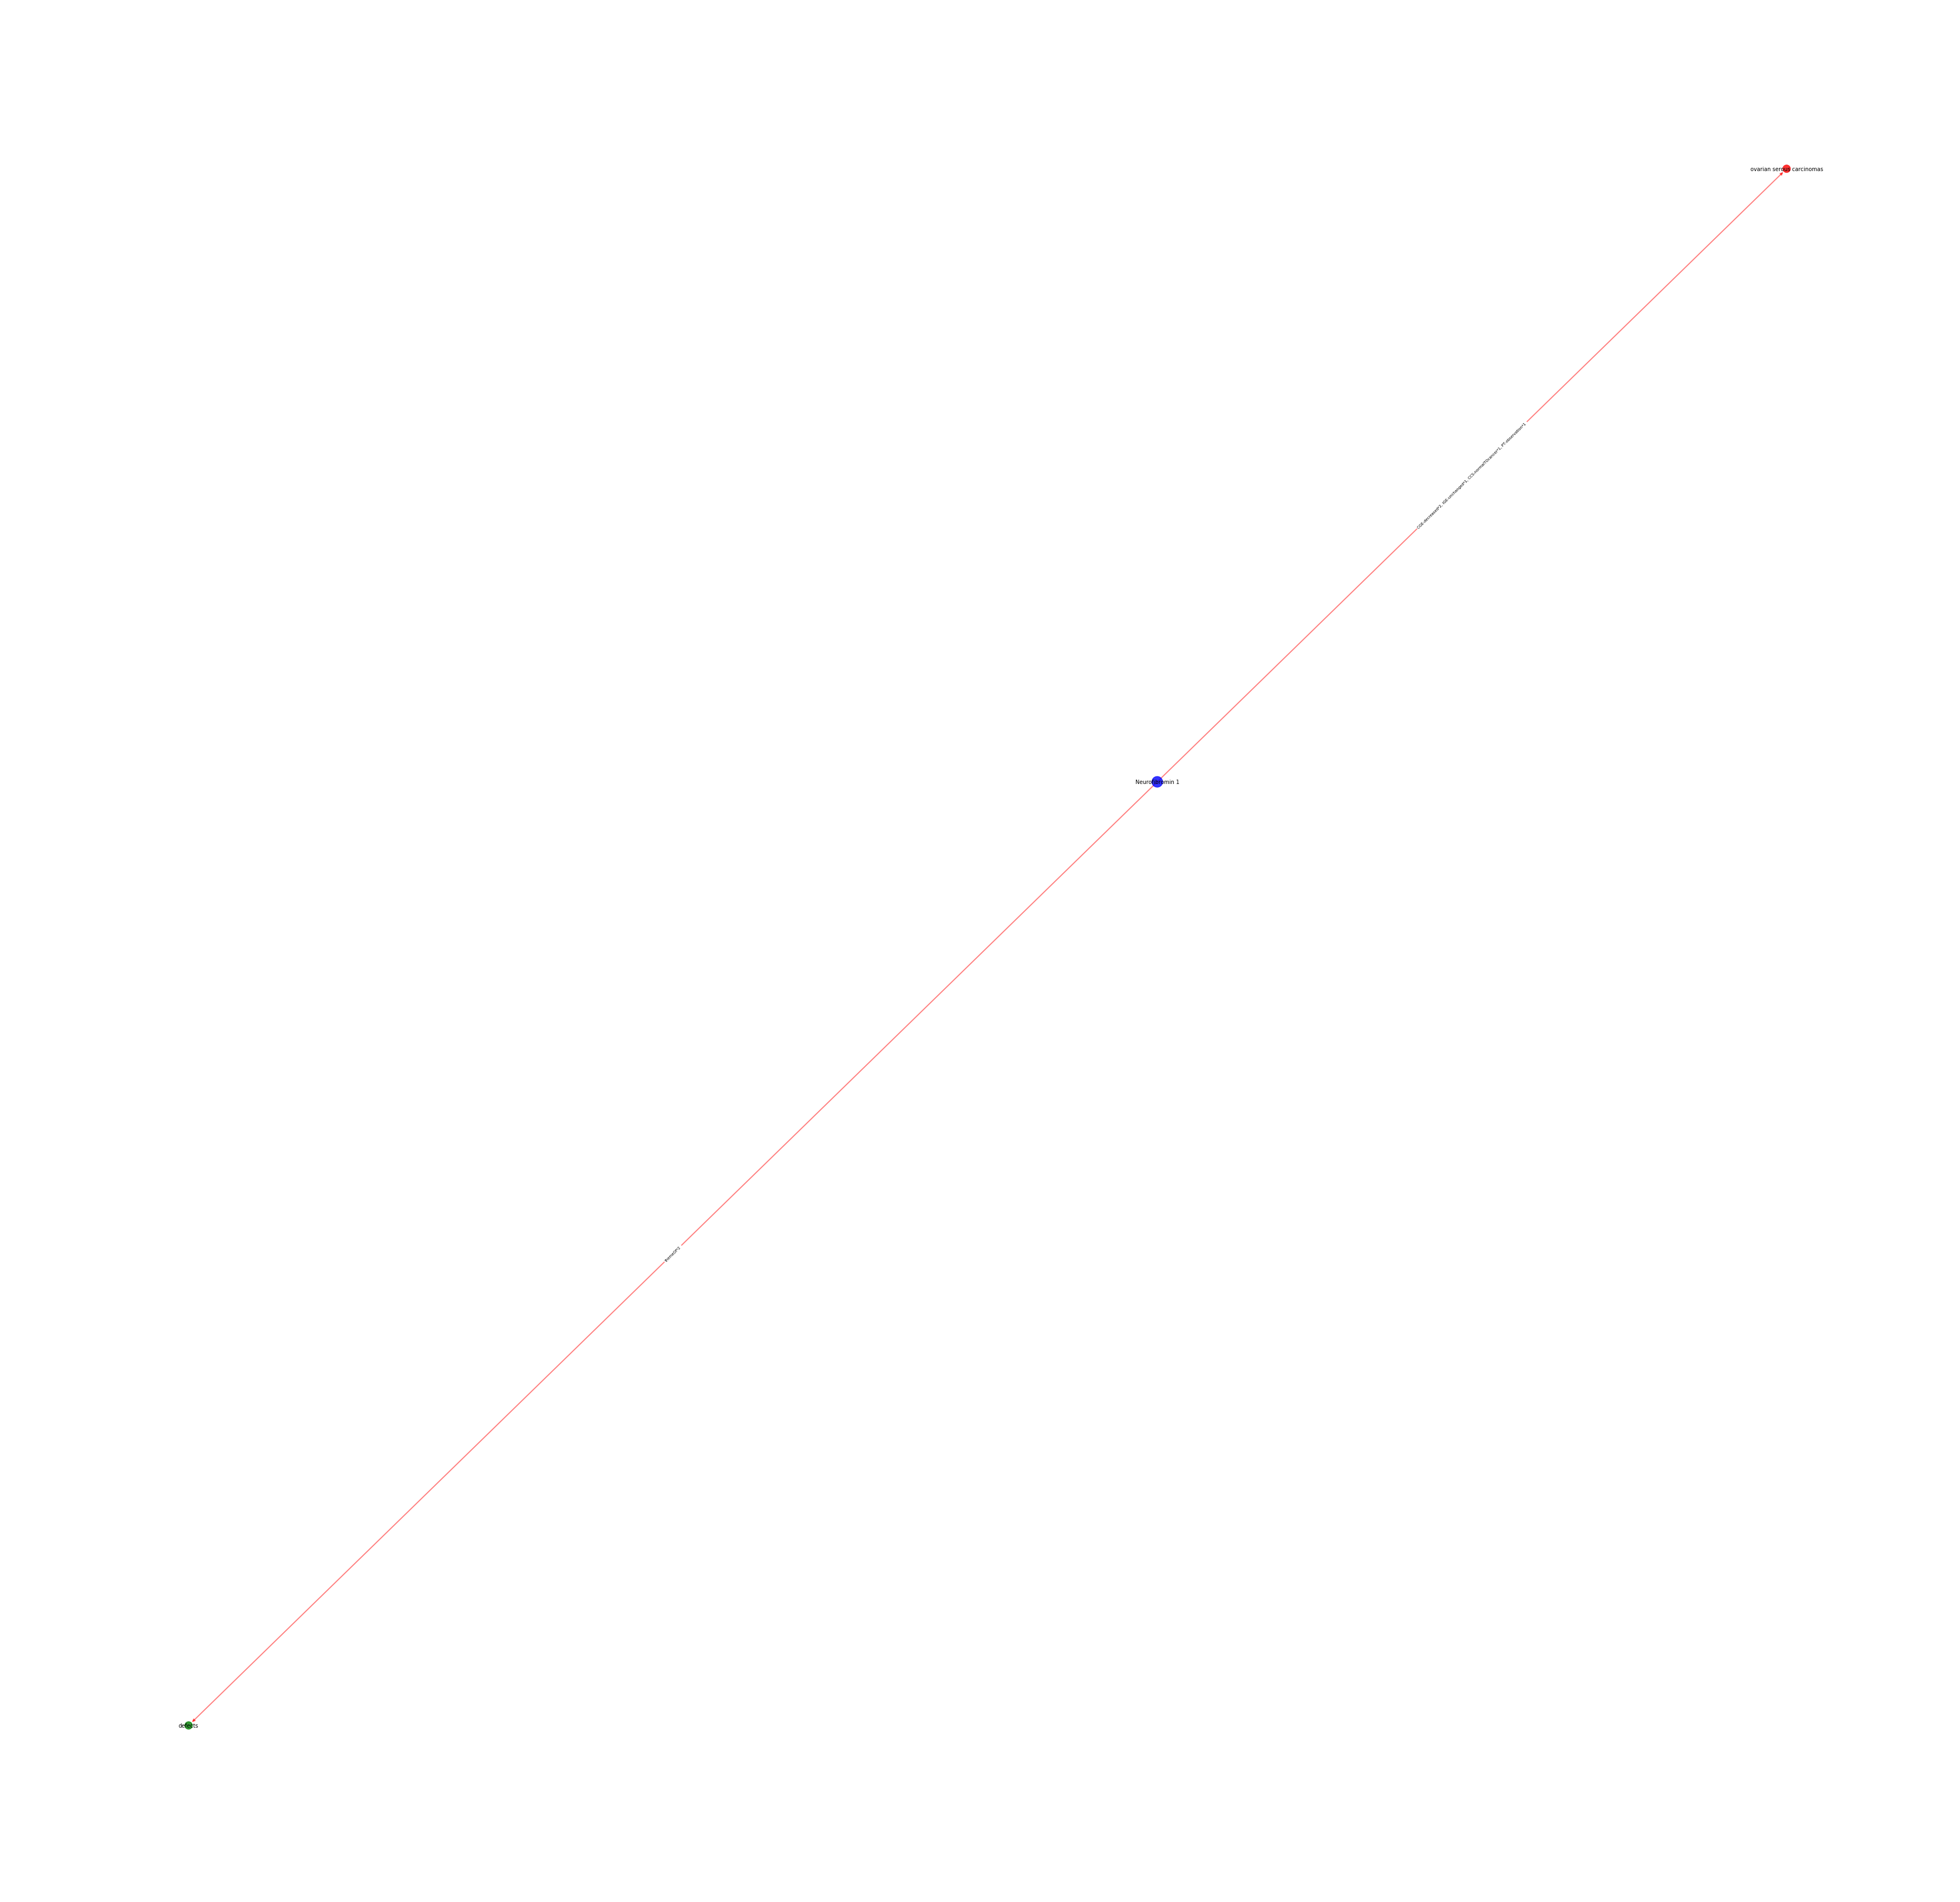

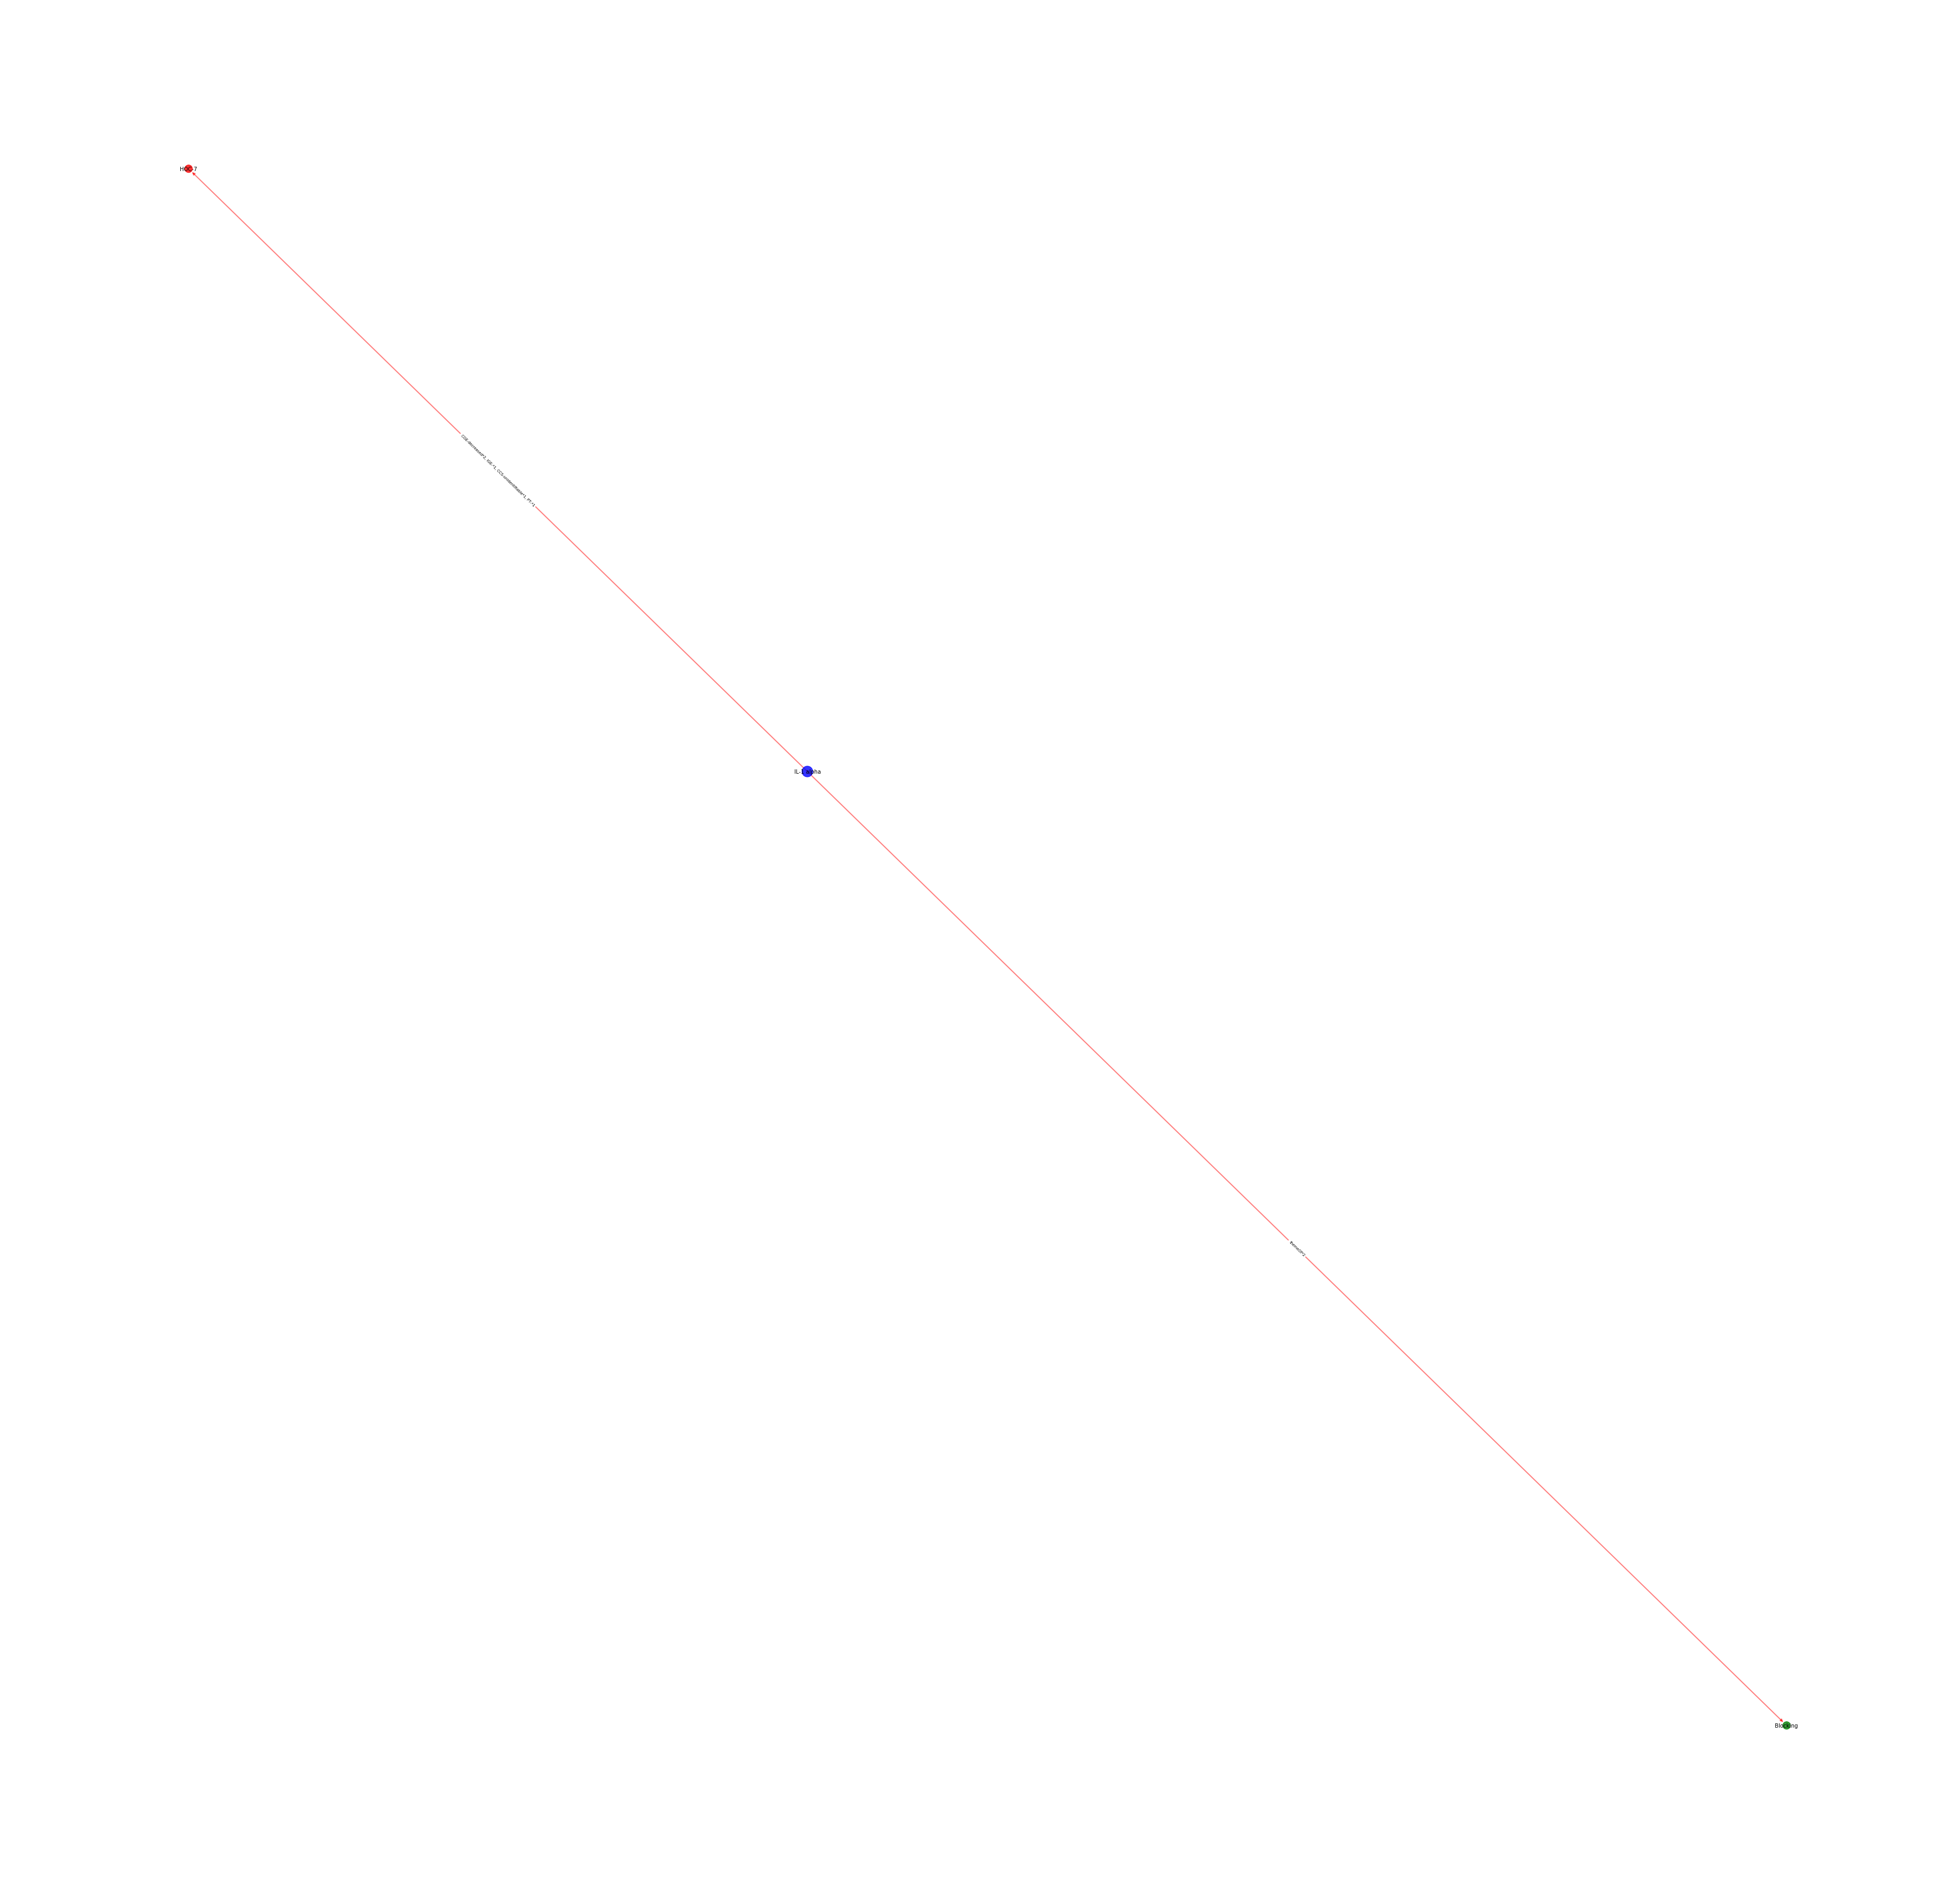

In [40]:
###try outs

# print()
nodes, n_labels = get_nodes_labels(nodes_info)
edges, e_labels = get_edges_labels_weights()

# a = [n for n in nodes if "e_" in n]
# print(a)


def initialize_graph(nodes, edges):
    g = nx.DiGraph()


    g.add_nodes_from(nodes)
    g.add_weighted_edges_from(edges)
    
    return g

def draw_graph (nodes, n_labels, edges, e_labels):
    g = initialize_graph(nodes, edges)
    n_out_degree = g.degree(nodes)
#     n_out_degree = dict(n_out_degree)

    min_pair = min(n_out_degree, key = lambda t: t[1])
    max_pair = max(n_out_degree, key = lambda t: t[1])
###
#     print(min_pair)
#     print(max_pair)

    node_sizes = compute_node_size(min_pair[1], max_pair[1], n_out_degree)
    

    for component in sorted(nx.weakly_connected_component_subgraphs(g), key = len, reverse = True):
    #     print(component.nodes())
        if len(component) < 2:
            continue
        #matplotlib graph size
        plt.figure(1, figsize = (64,64))

        #networkx layout
        pos = nx.spring_layout(component)
        #pos = nx.circular_layout(component)

        #subgraph nodes and labels
        cmp_n_labels = dict((key, value) for key, value in n_labels.items() if key in component.nodes())
        cmp_n_colors = list()
        for key in component.nodes():
            if "g_" in key:
                value = "b"
            elif "d_" in key:
                value = "r"
            else:
                value = "g"
            cmp_n_colors.append(value)
        
        nx.draw_networkx_nodes(component, pos, nodelist = component.nodes(), node_color=cmp_n_colors, 
                               node_size = [v[1] for v in node_sizes if v[0] in component.nodes()], alpha=0.8)
        nx.draw_networkx_labels(component, pos, cmp_n_labels, font_size=10)

        #subgraph edges and labels
        cmp_e_labels = dict((key, value) for key, value in e_labels.items() if key in component.edges())

        nx.draw_networkx_edges(component, pos, edgelist=component.edges(), width=2, alpha=0.5, edge_color='r')
        nx.draw_networkx_edge_labels(component, pos, edge_labels = cmp_e_labels, font_size=7)

        plt.axis('off')
        plt.savefig("test.pdf")
#         break
        plt.show()
        
draw_graph(nodes, n_labels, edges, e_labels)

### ---------------------------------------------------------

In [41]:
text = "Hello, world. Regular expressions are not always the answer."
partitions = text.partition("Hello,")
print(partitions)
pref_words = list(filter(None, partitions[0].split(" ")))
print(pref_words)
print()
if(len(pref_words)>1):
    print("l1: ",pref_words[len(pref_words)-1])
    print("l2: ",pref_words[len(pref_words)-2])
elif(len(pref_words)>0 and pref_words[len(pref_words)-1]):
    print("l1: ",pref_words[len(pref_words)-1])
    
postf_words = list(filter(None, partitions[2].split(" ")))
print(postf_words)
print()
if(len(postf_words)>1):
    print("0: ",postf_words[0])
    print("1: ",postf_words[1])
elif(len(postf_words)>0 and postf_words[0]):
    print("0: ",postf_words[0])

('', 'Hello,', ' world. Regular expressions are not always the answer.')
[]

['world.', 'Regular', 'expressions', 'are', 'not', 'always', 'the', 'answer.']

0:  world.
1:  Regular
